<a href="https://colab.research.google.com/github/Yooru6/Keras-MNIST-FMNIST/blob/master/CONV_FMNIST_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion-MNIST - Convolutional

### Change tensorflow version to 1.x

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import tensorflow as tf
import numpy as np

import distutils
if distutils.version.LooseVersion(tf.__version__) < '1.14':
    raise Exception('This notebook is compatible with TensorFlow 1.14 or higher, for TensorFlow 1.13 or lower please use the previous version at https://github.com/tensorflow/tpu/blob/r1.13/tools/colab/fashion_mnist.ipynb')



## Dataset
- loading dataset
- Changing type of values and adding dimenson
- Creating training-, validation- and testing dataset

In [0]:
(train_data, y_train),(test_data, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# adding empty color dimension on data

# 60 000 samples
x_train = np.expand_dims(train_data, -1).astype(np.float32)

# 2000 samples
x_test = np.expand_dims(test_data[8000:], -1).astype(np.float32)
y_test = test_labels[8000:].astype(np.float32)

# 8000 samples
x_val=np.expand_dims(test_data[:8000], -1).astype(np.float32)
y_val=test_labels[:8000].astype(np.float32)

In [0]:
x_train.shape

(60000, 28, 28, 1)

## Model
- Creating Convolutional model model

In [0]:
def create_model():
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(256))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.Dropout(0.4))
  model.add(tf.keras.layers.Dense(10))
  model.add(tf.keras.layers.Activation('softmax'))
  return model

### Compile and Enable TPU's
- using decaying learning rate for optimizer

In [0]:
import os


resolver = tf.contrib.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.contrib.distribute.initialize_tpu_system(resolver)
strategy = tf.contrib.distribute.TPUStrategy(resolver)

LEARNING_RATE=0.006
LEARNING_RATE_EXP_DECAY=0.8 if strategy.num_replicas_in_sync == 1 else 0.9

#strategy.scope for tpu
with strategy.scope():
  model = create_model()
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'])

# learning rate decay(Fine tuning lr during epochs)
lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Initializing the TPU system: 10.64.106.250:8470
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.64.106.250:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 17860401580427362090)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 16966050736277472347)

## Train
- using TPU(tensor processing units)
- epochs = 10

In [0]:
#Fit
history = model.fit(
    x_train.astype(np.float32), y_train.astype(np.float32),
    epochs=10,
    steps_per_epoch=60,
    validation_data=(x_val.astype(np.float32), y_val.astype(np.float32)),
#    validation_freq=1,
    callbacks=[lr_decay]
)
#Save Model
model.save_weights('./fashion_mnist.h5', overwrite=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 00001: LearningRateScheduler reducing learning rate to 0.006.
Epoch 1/10
60/60 [==============================] - 7s 110ms/step - loss: 0.8031 - acc: 0.7153 - val_loss: 1.3080 - val_acc: 0.5206

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0054.
Epoch 2/10
60/60 [==============================] - 6s 94ms/step - loss: 0.4343 - acc: 0.8422 - val_loss: 1.7475 - val_acc: 0.2748

Epoch 00003: LearningRateScheduler reducing learning rate to 0.004860000000000001.
Epoch 3/10
60/60 [==============================] - 6s 99ms/step - loss: 0.3627 - acc: 0.8697 - val_loss: 1.9107 - val_acc: 0.2270

Epoch 00004: LearningRateScheduler reducing learning rate to 0.004374.
Epoch 4/10
60/60 [==============================] - 7s 111ms/step - loss: 0.3182 - acc: 0.8851 - val_loss: 1.8159 - val_acc: 0.2891

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0039366.
Epoch 5/10
6

## Evaluate
- Evaluating model with separate testing data(x_test)
  - had to create separate model and load weight because can't use model.evaluate() command with tpu
- Plotting accuracy and loss graph

In [0]:
# Test model

#cpu_model = create_model()
cpu_model = create_model()
cpu_model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'])


cpu_model.load_weights('./fashion_mnist.h5')

test_loss, test_acc = cpu_model.evaluate(x_test.astype(np.float32),  y_test.astype(np.float32), batch_size=128)
print('\nTest accuracy:', test_acc)

2000/2000 [==============================] - 1s 369us/sample - loss: 0.2178 - acc: 0.9175

Test accuracy: 0.9175


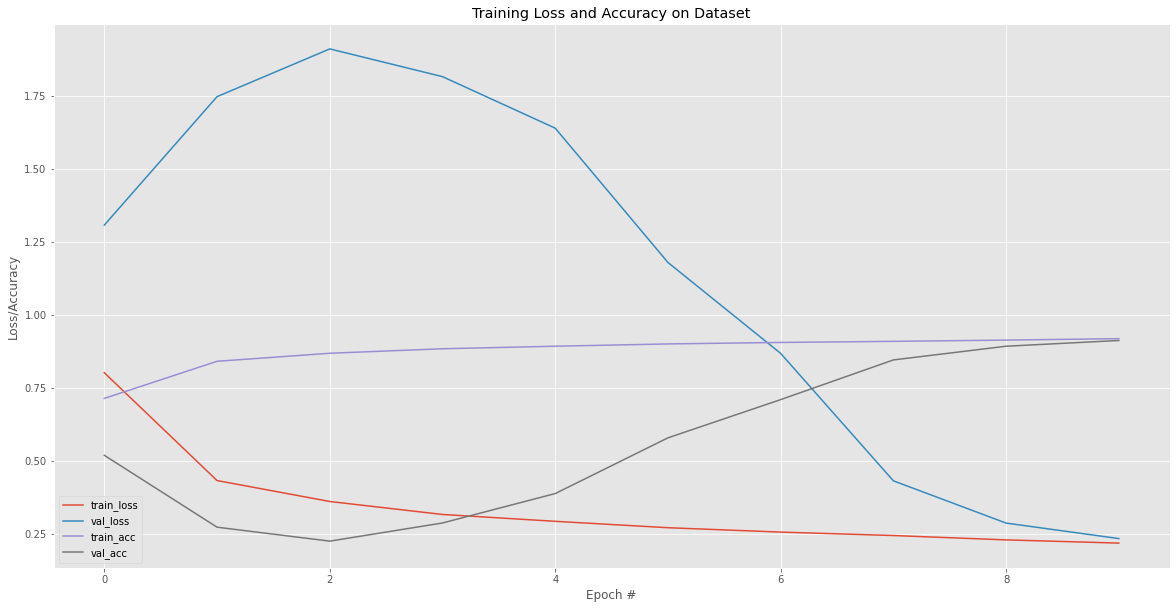

In [0]:
import matplotlib.pyplot as plt
# plot the training loss and accuracy
N = 10
plt.style.use("ggplot")
plt.figure(figsize=(20,10))
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

## Plot predictions
- plotting 16 predictions with images and labels. Also including confidence of model(%)

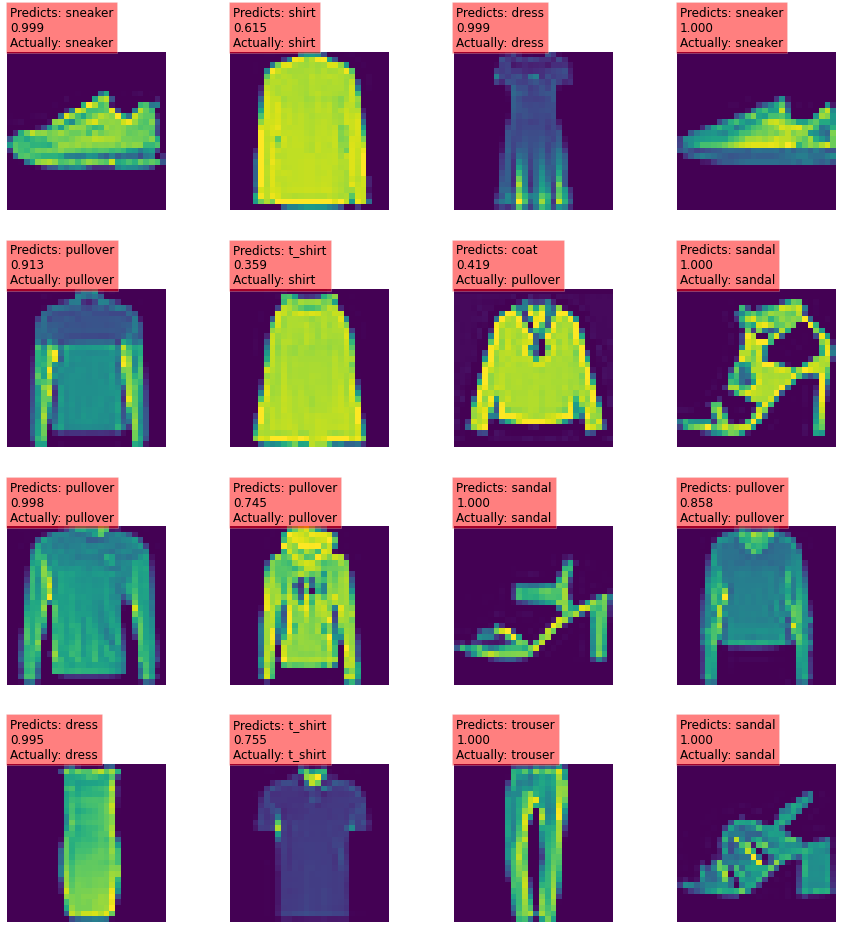

In [0]:
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']


#cpu_model = create_model()
#cpu_model.load_weights('./fashion_mnist.h5')

from matplotlib import pyplot
%matplotlib inline

def plot_predictions(images, predictions):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  f, axes = pyplot.subplots(nc, 4)
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')
    
    actual_label = LABEL_NAMES[int(y_test[i])]
    label = LABEL_NAMES[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[x, y].imshow(images[i])
    axes[x, y].text(0, -1.5,"Predicts: "+ label + '\n%.3f' % +confidence+"\n"+"Actually: "+actual_label, fontsize=12,bbox=dict(facecolor='red', alpha=0.5))
    pyplot.subplots_adjust(wspace=0,hspace=0.5)

  pyplot.gcf().set_size_inches(16, 16)  

plot_predictions(np.squeeze(x_test[:16]), 
                 model.predict(x_test[:16]))